In [4]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import importlib
import sys
import os

path_ = os.path.abspath(os.path.join('..', '00_utils_training'))

if path_ not in sys.path:
    sys.path.append(path_)

import run_train_toy

In [6]:
importlib.reload(run_train_toy)
TrainerToy = run_train_toy.TrainerToy

def load_trainer(type_):
    data_params_ho = {
        'N': 200,
        'noise_level': 0.2,
        'ode_type': "harmonic_oscillator",
        'data_param': {"omega_squared": 2},
        'start_time': 0,
        'end_time': 10,
        'spacing_type': "chebyshev",
        'initial_state': np.array([0.0, 1.0])
    }

    data_params_vdp = {
        'N': 200,
        'noise_level': 0.1,
        'ode_type': "van_der_pol",
        'data_param': {"mu": 1, "omega": 1},
        'start_time': 0,
        'end_time': 15,
        'spacing_type': "chebyshev",
        'initial_state': np.array([0.0, 1.0])
    }

    data_params_do = {
        'N': 200,
        'noise_level': 0.1,
        'ode_type': "damped_oscillation",
        'data_param': {"damping_factor": 0.1, "omega_squared": 1},
        'start_time': 0,
        'end_time': 10,
        'spacing_type': "chebyshev",
        'initial_state': np.array([0.0, 1.0])
    }

    if type_ == "ho":
        p_ = data_params_ho
    elif type_ == "vdp":
        p_ = data_params_vdp
    elif type_ == "do":
        p_ = data_params_do
    else:
        raise ValueError(f"Invalid type {type_}")

    trainer = PyomoTrainerToy(p_, model_type="pyomo")
    trainer.prepare_inputs()
    return trainer

In [7]:
def extract_metrics(results_dict):
    time_elapsed, mse_train, mse_test = [], [], []
    for key, value in results_dict.items():
        time_elapsed.append(value['time_elapsed'])
        mse_train.append(value['mse_train'].item())
        mse_test.append(value['mse_test'].item())
    return time_elapsed, mse_train, mse_test

### Reducing the number of collocation constraints

In [60]:
fn = '2024-08-16_20-58-35_ho_constr_n.pkl'
with open(f'results/{fn}', 'rb') as file:
    results_ho_constr_n = pickle.load(file)

In [74]:
[int(200 - 200//k)/200 for k  in keys]

[1.0, 0.96, 0.9, 0.8, 0.5, 0.0]

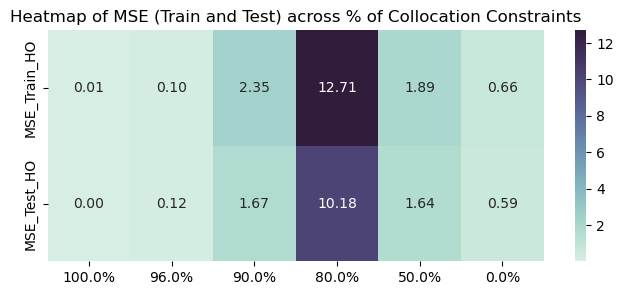

In [84]:
time_elapsed_ho, mse_train_ho, mse_test_ho = extract_metrics(results_ho_constr_n)
keys = list(results_ho_constr_n.keys())

df = pd.DataFrame({
    #'Reg_Strength': keys,
    # 'Time Elapsed HO': time_elapsed_ho,
    'MSE_Train_HO': mse_train_ho,
    'MSE_Test_HO': mse_test_ho,
}).T

#pivot_table = df.pivot(index='Reg_Strength', columns=['consrtaint_tol'], values='MSE_Train_HO')
cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True, light=0.9)
                       
tick_positions = np.arange(len(keys))  # Use np.arange for exact index positions
tick_labels = [str(np.round(int(200 - 200//k)/2))+'%' for k  in keys]
                             
plt.figure(figsize=(8, 3))
ax = sns.heatmap(df, annot=True, fmt=".2f", cmap=cmap, annot_kws={'size': 10})

plt.title('Heatmap of MSE (Train and Test) across % of Collocation Constraints')

ax.set_xticks(tick_positions + 0.5)  
ax.set_xticklabels(tick_labels)

plt.show()

### Regularization

In [8]:
with open('results/pyomo_results_reg_2024-08-14_11-05-41.pkl', 'rb') as file:
    results_reg_ho = pickle.load(file)

with open('results/pyomo_results_reg_2024-08-14_11-48-20.pkl', 'rb') as file:
    results_reg_vdp = pickle.load(file)
    
with open('results/pyomo_results_reg_2024-08-14_11-53-46.pkl', 'rb') as file:
    results_reg_do = pickle.load(file)

with open('results/pyomo_results_reg_2024-08-14_11-02-19.pkl', 'rb') as file:
    results_reg_norm = pickle.load(file) # ho
    
keys = list(results_reg_ho.keys())

time_elapsed_ho, mse_train_ho, mse_test_ho = extract_metrics(results_reg_ho)
time_elapsed_vdp, mse_train_vdp, mse_test_vdp = extract_metrics(results_reg_vdp)
time_elapsed_do, mse_train_do, mse_test_do = extract_metrics(results_reg_do)
    
df = pd.DataFrame({
    'Reg Strength': keys,
    'Time Elapsed HO': time_elapsed_ho,
    'Time Elapsed VDP': time_elapsed_vdp,
    'Time Elapsed DO': time_elapsed_do,
    'MSE Train HO': mse_train_ho,
    'MSE Train VDP': mse_train_vdp,
    'MSE Train DO': mse_train_do,
    'MSE Test HO': mse_test_ho,
    'MSE Test VDP': mse_test_vdp,
    'MSE Test DO': mse_test_do
})

display(df.T)


,0,1,2,3,4,5,6,7
Reg Strength,1.000000e-07,0.000001,0.000010,0.000100,0.001000,0.010000,0.100000,1.000000
Time Elapsed HO,2.977461e+01,32.508947,7.946084,2.799575,2.202133,1.532549,2.585719,4.720815
Time Elapsed VDP,8.211527e+00,10.522110,17.918370,7.372392,4.877921,3.461447,4.497927,158.613230
Time Elapsed DO,3.338108e+01,21.102988,11.935450,4.977235,3.874517,5.502752,3.202409,7.061539
MSE Train HO,6.538150e-01,0.340933,0.263469,0.002165,0.006104,0.006077,0.012205,0.447567
MSE Train VDP,3.059666e+00,2.391632,0.274181,0.054286,0.019385,0.073406,0.389387,0.448215
MSE Train DO,3.936542e+03,307.674292,0.047853,0.003419,0.001587,0.001119,0.004324,0.303106
MSE Test HO,5.211926e-01,2739.150374,245.166154,0.006502,0.003539,0.003822,0.022846,0.842995
MSE Test VDP,1.803162e+02,9.027527,34.268013,0.502660,0.467538,0.975101,2.330266,4.173948
MSE Test DO,7.039467e-01,4.558237,4.075259,0.018929,0.010591,0.001193,0.006506,1.251870


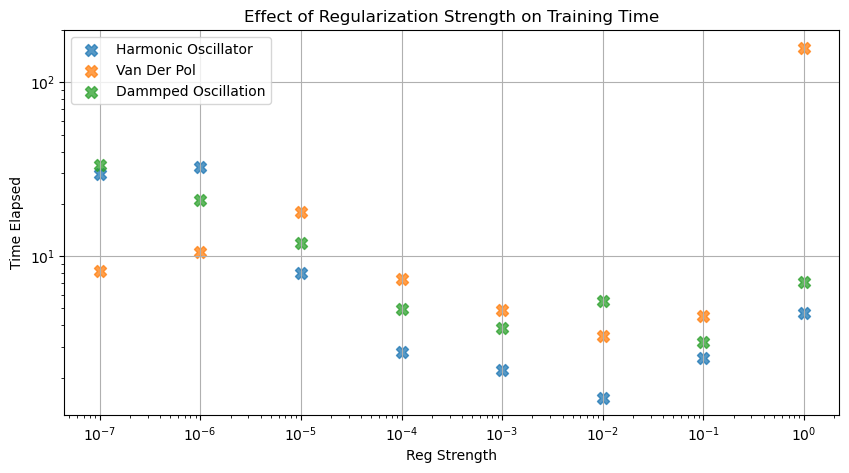

In [9]:
plt.figure(figsize=(10, 5))
plt.grid()
mark = 'X'
s = 75
alpha = 0.75
plt.scatter(keys, time_elapsed_ho, s = s, marker=mark, label = 'Harmonic Oscillator', alpha = alpha)
plt.scatter(keys, time_elapsed_vdp, s = s, marker=mark, label = 'Van Der Pol', alpha = alpha)
plt.scatter(keys, time_elapsed_do, s = s, marker=mark, label = 'Dammped Oscillation', alpha = alpha)
plt.title('Effect of Regularization Strength on Training Time')
plt.xlabel('Reg Strength')
plt.ylabel('Time Elapsed')  
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

In [12]:
if trainer:
    r = 0.0001
    result = results_reg_vdp[r]

    y_pred = result['odeint_pred']
    y_pred_test = result['odeint_pred_test']

    plt.figure(figsize=(10, 6))

    plt.plot(trainer.t, trainer.y[:,0], color = 'blue', label='True Data (Train)', alpha = 0.6)
    plt.plot(trainer.t, trainer.y[:,1], color = 'blue', alpha = 0.6)
    plt.scatter(trainer.t, y_pred[:,0], color = 'blue', label='Predicted Trajectory (Train)', alpha = 0.6)
    plt.scatter(trainer.t, y_pred[:,1], color = 'blue', alpha = 0.6)

    plt.plot(trainer.t_test, trainer.y_test[:,0], color='#FF8C10', label='True Data (Test)', alpha = 0.6)
    plt.plot(trainer.t_test, trainer.y_test[:,1], color='#FF8C10', alpha = 0.6)
    plt.scatter(trainer.t_test, y_pred_test[:,0], color='#FF8C00', label='Predicted Trajectory (Test)', alpha = 0.6)
    plt.scatter(trainer.t_test, y_pred_test[:,1], color='#FF8C00', alpha = 0.6)

    plt.title(f"Collocation-based neural ODE training (Damped Oscilltor) with $\lambda$ = {r}")
    plt.xlabel("Time")
    plt.ylabel("State")
    plt.legend(loc ="upper left")
    plt.grid(True)
    plt.show()

NameError: name 'trainer' is not defined

## LD

In [33]:
fn = '2024-08-16_17-37-12_reg_gl_ho.pkl'
with open(f'results/{fn}', 'rb') as file:
    results_reg_ho = pickle.load(file)
    
fn = '2024-08-16_18-24-34_reg_vdp_gl.pkl'
with open(f'results/{fn}', 'rb') as file:
    results_reg_vdp = pickle.load(file)
    
fn = '2024-08-16_18-41-43_reg_do_gl.pkl'
with open(f'results/{fn}', 'rb') as file:
    results_reg_do = pickle.load(file)
    
keys = list(results_reg_ho.keys())

results_reg_do = list(results_reg_do.items())
results_reg_do.insert(0, (0, {'time_elapsed': np.array(np.nan), 'mse_train': np.array(np.nan), 'mse_test': np.array(np.nan)}))
results_reg_do = dict(results_reg_do)

time_elapsed_ho, mse_train_ho, mse_test_ho = extract_metrics(results_reg_ho)
time_elapsed_vdp, mse_train_vdp, mse_test_vdp = extract_metrics(results_reg_vdp)
time_elapsed_do, mse_train_do, mse_test_do = extract_metrics(results_reg_do)
    
df = pd.DataFrame({
    'Reg Strength': keys,
    'Time Elapsed HO': time_elapsed_ho,
    'Time Elapsed VDP': time_elapsed_vdp,
    'Time Elapsed DO': time_elapsed_do,
    'MSE Train HO': mse_train_ho,
    'MSE Train VDP': mse_train_vdp,
    'MSE Train DO': mse_train_do,
    'MSE Test HO': mse_test_ho,
    'MSE Test VDP': mse_test_vdp,
    'MSE Test DO': mse_test_do
})

display(df.T)


,0,1,2,3,4,5
Reg Strength,0.0,0.000001,0.0001,0.01,0.1,1.0
Time Elapsed HO,542.626417,156.100788,3.21836,2.472349,2.202613,8.600358
Time Elapsed VDP,152.875177,17.355022,6.315841,2.961077,3.288942,11.632255
Time Elapsed DO,nan,97.248757,3.80045,2.704986,2.932369,5.488711
MSE Train HO,27170.996018,2787.494739,0.002236,0.006104,0.012245,0.450414
MSE Train VDP,3.053859,245.939868,0.022058,0.070739,0.391441,2.581614
MSE Train DO,NaN,7.594268,0.003468,0.001127,0.004339,0.305019
MSE Test HO,0.876986,0.623553,0.00653,0.003811,0.022738,0.841134
MSE Test VDP,4.361434,1858.491905,1.047934,0.831485,2.324695,6.458044
MSE Test DO,NaN,0.26085,0.019561,0.001186,0.006545,1.252703


### Pre-Training

In [184]:
results_pre_init

{'ho': {'time_elapsed': 1.598968744277954,
  'direct_model_pred': [array([ 9.17288340e-02,  9.23797088e-02,  9.43316177e-02,  9.75823883e-02,
           1.02128314e-01,  1.07964025e-01,  1.15082309e-01,  1.23473885e-01,
           1.33127129e-01,  1.44027753e-01,  1.56158445e-01,  1.69498467e-01,
           1.84023221e-01,  1.99703777e-01,  2.16506375e-01,  2.34391907e-01,
           2.53315369e-01,  2.73225313e-01,  2.94063272e-01,  3.15763198e-01,
           3.38250888e-01,  3.61443427e-01,  3.85248637e-01,  4.09564563e-01,
           4.34278968e-01,  4.59268892e-01,  4.84400241e-01,  5.09527461e-01,
           5.34493277e-01,  5.59128541e-01,  5.83252199e-01,  6.06671408e-01,
           6.29181830e-01,  6.50568135e-01,  6.70604766e-01,  6.89056977e-01,
           7.05682216e-01,  7.20231877e-01,  7.32453457e-01,  7.42093152e-01,
           7.48898908e-01,  7.52623920e-01,  7.53030572e-01,  7.49894749e-01,
           7.43010473e-01,  7.32194733e-01,  7.17292393e-01,  6.98181025e-01,


In [85]:
with open('results/2024-08-14_15-12-57_pre_init.pkl', 'rb') as file:
    results_pre_init = pickle.load(file)

with open('results/2024-08-14_15-14-45_NO_pre_init.pkl', 'rb') as file:
    results_no_init = pickle.load(file)
    
keys = list(results_pre_init.keys())

time_elapsed_pre_init, mse_train_pre_init, mse_test_pre_init = extract_metrics(results_pre_init)
time_elapsed_no_init, mse_train_no_init, mse_test_no_init = extract_metrics(results_no_init)

In [86]:
df = pd.DataFrame({
    'Keys': keys,
    'Time Elapsed PRE': time_elapsed_pre_init,
    'Time Elapsed NO': time_elapsed_no_init,
    
    'MSE Train PRE': mse_train_pre_init,
    'MSE Train NO': mse_train_no_init,
    
    'MSE Test PRE': mse_test_pre_init,
    'MSE Test NO': mse_test_no_init,
})


df.T


,0,1,2
Keys,ho,vdp,do
Time Elapsed PRE,1.598969,3.676053,1.82936
Time Elapsed NO,4.335938,6.335849,3.319605
MSE Train PRE,0.006077,0.073406,0.000981
MSE Train NO,0.005996,0.074356,0.000981
MSE Test PRE,0.003822,0.975101,0.000239
MSE Test NO,0.003795,0.978592,0.000239


### Tolerances

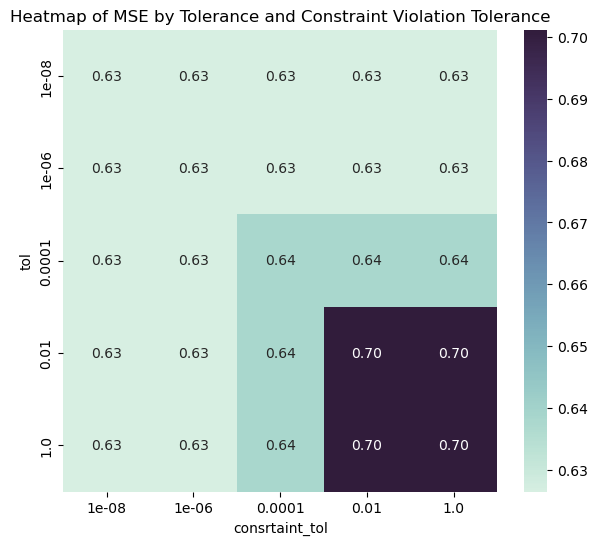

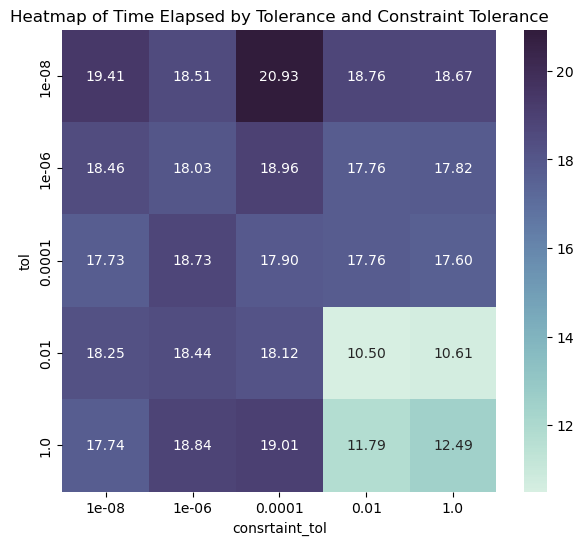

In [93]:
# [2, 16, 2]
with open('results/2024-08-14_17-06-25_tolerances.pkl', 'rb') as file:
    results_tolerances = pickle.load(file)

# [2, 64, 2]; vdp
with open('results/2024-08-14_18-07-50_tolerances.pkl', 'rb') as file:
    results_tolerances = pickle.load(file)

"""fn = '2024-08-15_15-03-57_tolerances_no_pretrain.pkl'
with open(f'results/{fn}', 'rb') as file:
    results_tolerances = pickle.load(file)
"""
keys = list(results_tolerances.keys())
time_elapsed, mse_train, mse_test = extract_metrics(results_tolerances)

tol = [key[0] for key in keys]
consrtaint_tol = [key[1] for key in keys]

data = pd.DataFrame({
    'tol': tol,
    'consrtaint_tol': consrtaint_tol,
    'time_elapsed': time_elapsed,
    'mse_train': mse_train,
    'mse_test': mse_test
})

pivot_table = data.pivot(index='tol', columns=['consrtaint_tol'], values='mse_test')
cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True, light=0.9)
                             
plt.figure(figsize=(7, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap=cmap, annot_kws={'size': 10})
plt.title('Heatmap of MSE by Tolerance and Constraint Violation Tolerance')
plt.show()

pivot_table = data.pivot(index='tol', columns=['consrtaint_tol'], values='time_elapsed')

plt.figure(figsize=(7, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap=cmap, annot_kws={'size': 10})
plt.title('Heatmap of Time Elapsed by Tolerance and Constraint Tolerance')
plt.show()

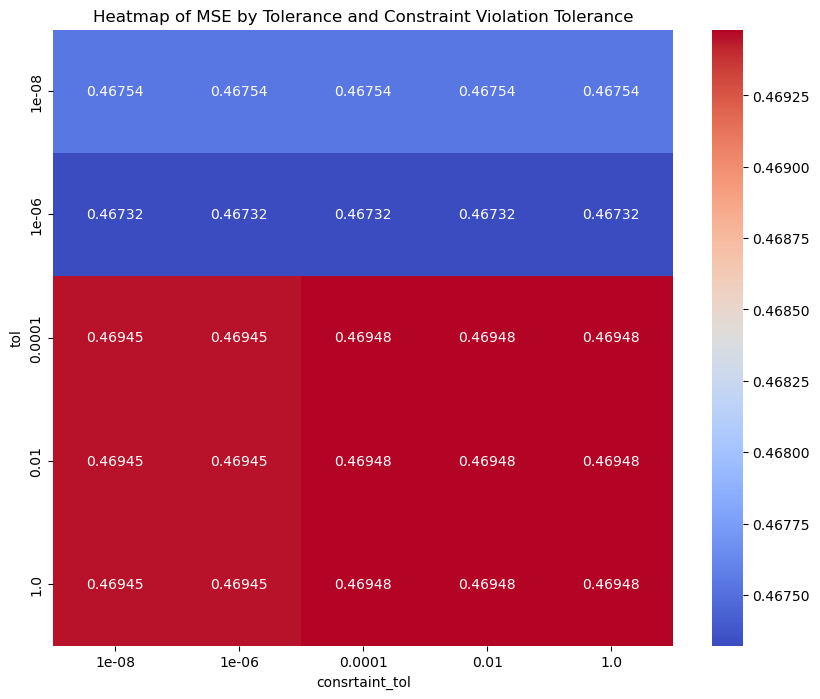

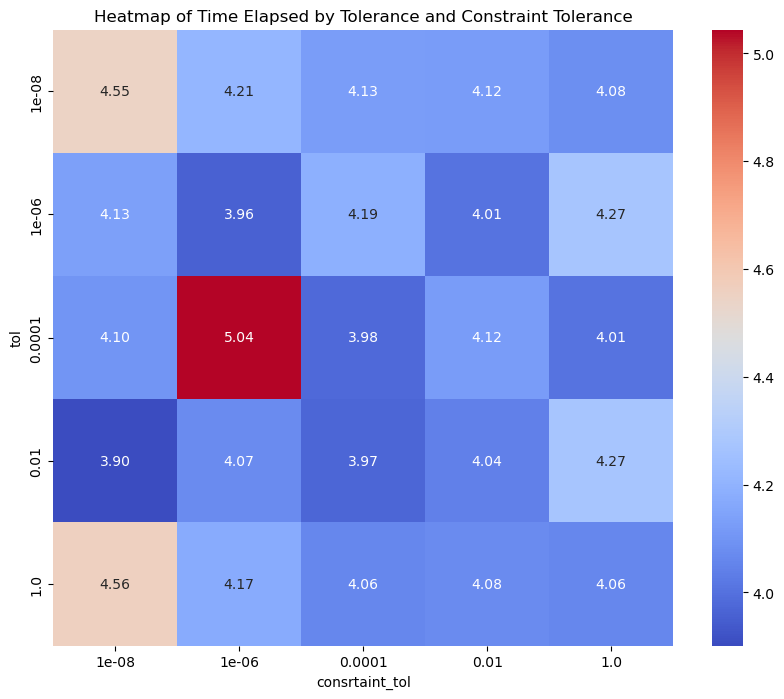

In [88]:
with open('results/2024-08-14_17-03-01_tolerances.pkl', 'rb') as file:
    results_tolerances = pickle.load(file)

keys = list(results_tolerances.keys())
time_elapsed, mse_train, mse_test = extract_metrics(results_tolerances)

tol = [key[0] for key in keys]
consrtaint_tol = [key[1] for key in keys]

data = pd.DataFrame({
    'tol': tol,
    'consrtaint_tol': consrtaint_tol,
    'time_elapsed': time_elapsed,
    'mse_train': mse_train,
    'mse_test': mse_test
})

pivot_table = data.pivot(index='tol', columns=['consrtaint_tol'], values='mse_test')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".5f", cmap='coolwarm')
plt.title('Heatmap of MSE by Tolerance and Constraint Violation Tolerance')
plt.show()

pivot_table = data.pivot(index='tol', columns=['consrtaint_tol'], values='time_elapsed')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Time Elapsed by Tolerance and Constraint Tolerance')
plt.show()

---

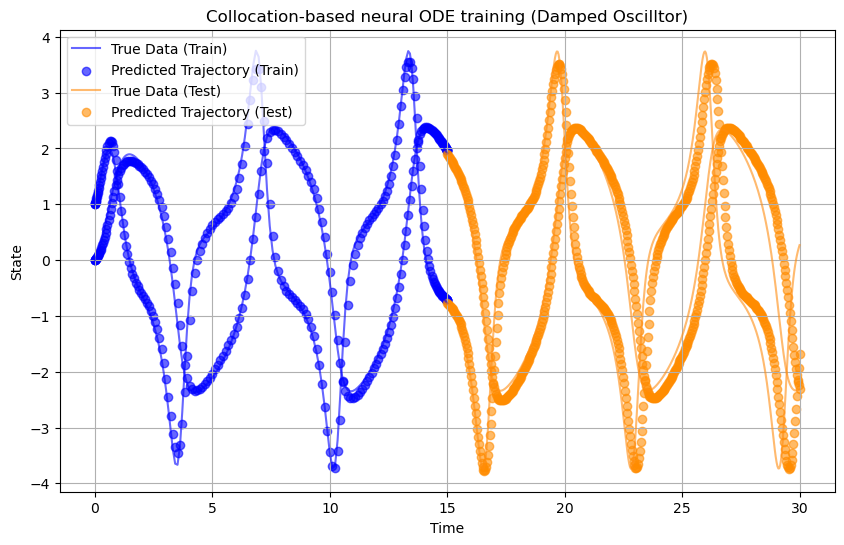

In [ ]:
result = results_tolerances[(1, 1)]

y_pred = result['odeint_pred']
y_pred_test = result['odeint_pred_test']

plt.figure(figsize=(10, 6))

plt.plot(trainer.t, trainer.y[:,0], color = 'blue', label='True Data (Train)', alpha = 0.6)
plt.plot(trainer.t, trainer.y[:,1], color = 'blue', alpha = 0.6)
plt.scatter(trainer.t, y_pred[:,0], color = 'blue', label='Predicted Trajectory (Train)', alpha = 0.6)
plt.scatter(trainer.t, y_pred[:,1], color = 'blue', alpha = 0.6)

plt.plot(trainer.t_test, trainer.y_test[:,0], color='#FF8C10', label='True Data (Test)', alpha = 0.6)
plt.plot(trainer.t_test, trainer.y_test[:,1], color='#FF8C10', alpha = 0.6)
plt.scatter(trainer.t_test, y_pred_test[:,0], color='#FF8C00', label='Predicted Trajectory (Test)', alpha = 0.6)
plt.scatter(trainer.t_test, y_pred_test[:,1], color='#FF8C00', alpha = 0.6)

plt.title(f"Collocation-based neural ODE training (Damped Oscilltor)")
plt.xlabel("Time")
plt.ylabel("State")
plt.legend(loc ="upper left")
plt.grid(True)
plt.show()

## Network Architecture

In [203]:
results_net_sizes

{}

In [204]:
file_name = "2024-08-14_17-53-06_network_sizes.pkl"
with open(f'results/{file_name}', 'rb') as file:
    results_net_sizes = pickle.load(file)

keys = list(results_net_sizes.keys())
time_elapsed, mse_train, mse_test = extract_metrics(results_net_sizes)

df = pd.DataFrame({
    'consrtaint_tol': keys,
    'time_elapsed': time_elapsed,
    'mse_train': mse_train,
    'mse_test': mse_test
})

df

,consrtaint_tol,time_elapsed,mse_train,mse_test
0,"[2, 4, 2]",1.802124,0.041125,0.636352
1,"[2, 8, 2]",2.082503,0.037405,0.979398
2,"[2, 16, 2]",4.156607,0.019385,0.467538
3,"[2, 32, 2]",7.680578,0.022517,0.613944
4,"[2, 64, 2]",18.175085,0.023645,0.626486
5,"[2, 128, 2]",31.460556,0.025816,0.559247


---
---

In [124]:
fn = '2024-08-19_21-15-03_training.pkl'
with open(f'results/{fn}', 'rb') as file:
    results_net_sizes = pickle.load(file)

keys = list(results_net_sizes.keys())
time_elapsed, mse_train, mse_test = extract_metrics(results_net_sizes)

df = pd.DataFrame({
    'consrtaint_tol': keys,
    'time_elapsed': time_elapsed,
    'mse_train': mse_train,
    'mse_test': mse_test
})

# drop rows with NaN
df = df.dropna()

In [125]:
df

,consrtaint_tol,time_elapsed,mse_train,mse_test
0,1,0.283032,17.222053,3.419121
1,2,0.428411,6.892097,11.078005
2,3,0.486208,6.149927,8.234912
3,4,0.632537,0.287523,1.964570
4,5,0.695010,0.457015,2.901127
5,6,0.785764,1.155527,3.480471
6,7,0.943075,0.289171,2.378571
7,8,1.284489,2.756576,6.349436
8,9,1.293624,0.307054,2.777716
9,10,1.147211,0.163385,1.699555


[]

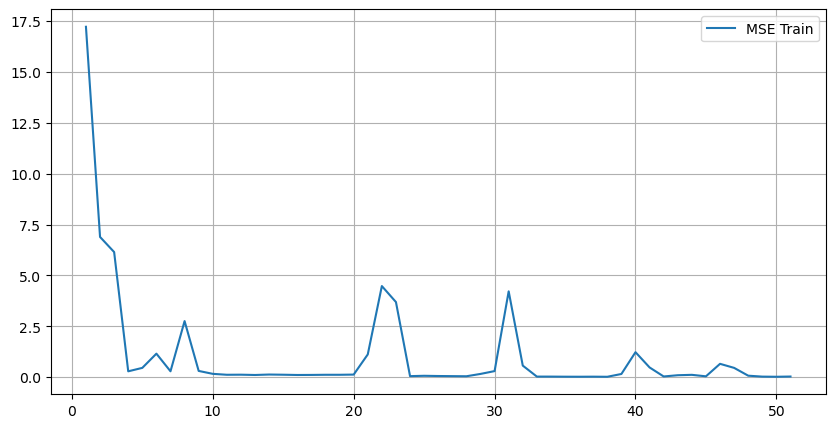

In [126]:
# plot
plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(df['consrtaint_tol'], df['mse_train'], label='MSE Train')
#plt.plot(df['consrtaint_tol'], df['mse_test'], label='MSE Test')
plt.legend()
plt.plot()